In [1]:
import numpy as np
import pandas as pd
from constants import *
from phe import *
from waves import *
import series as s

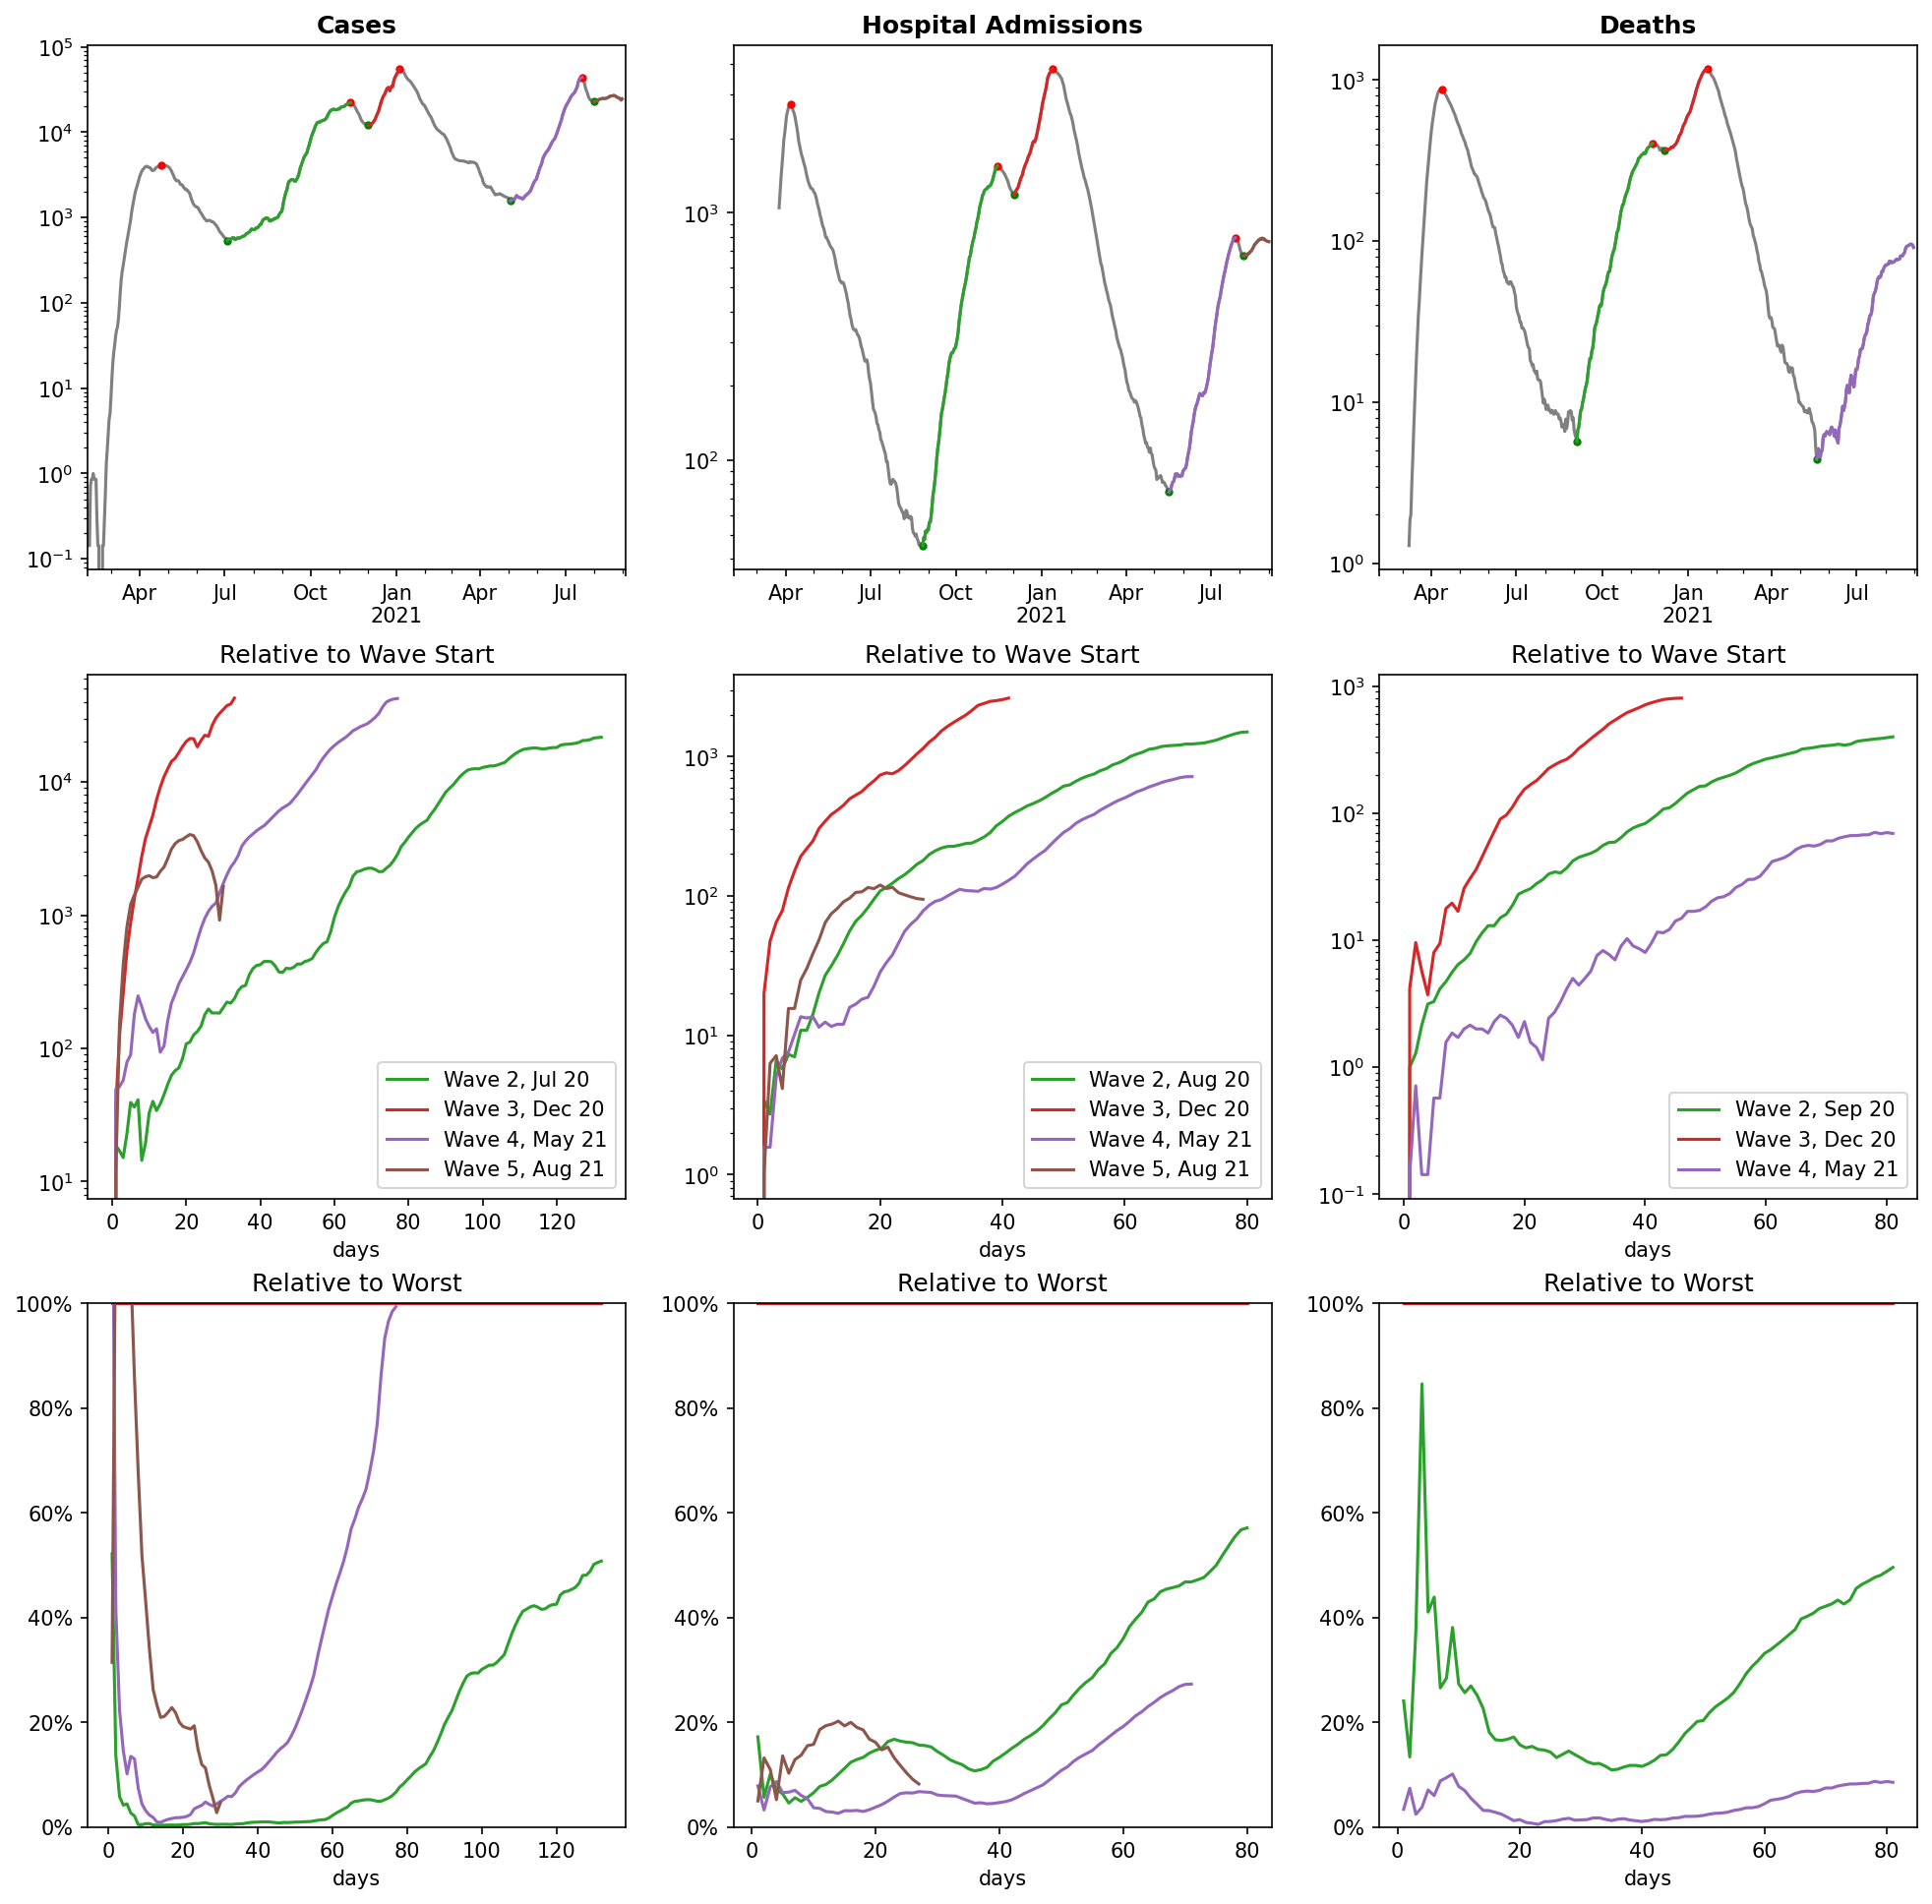

In [3]:
plot_all(figsize=(16, 16))

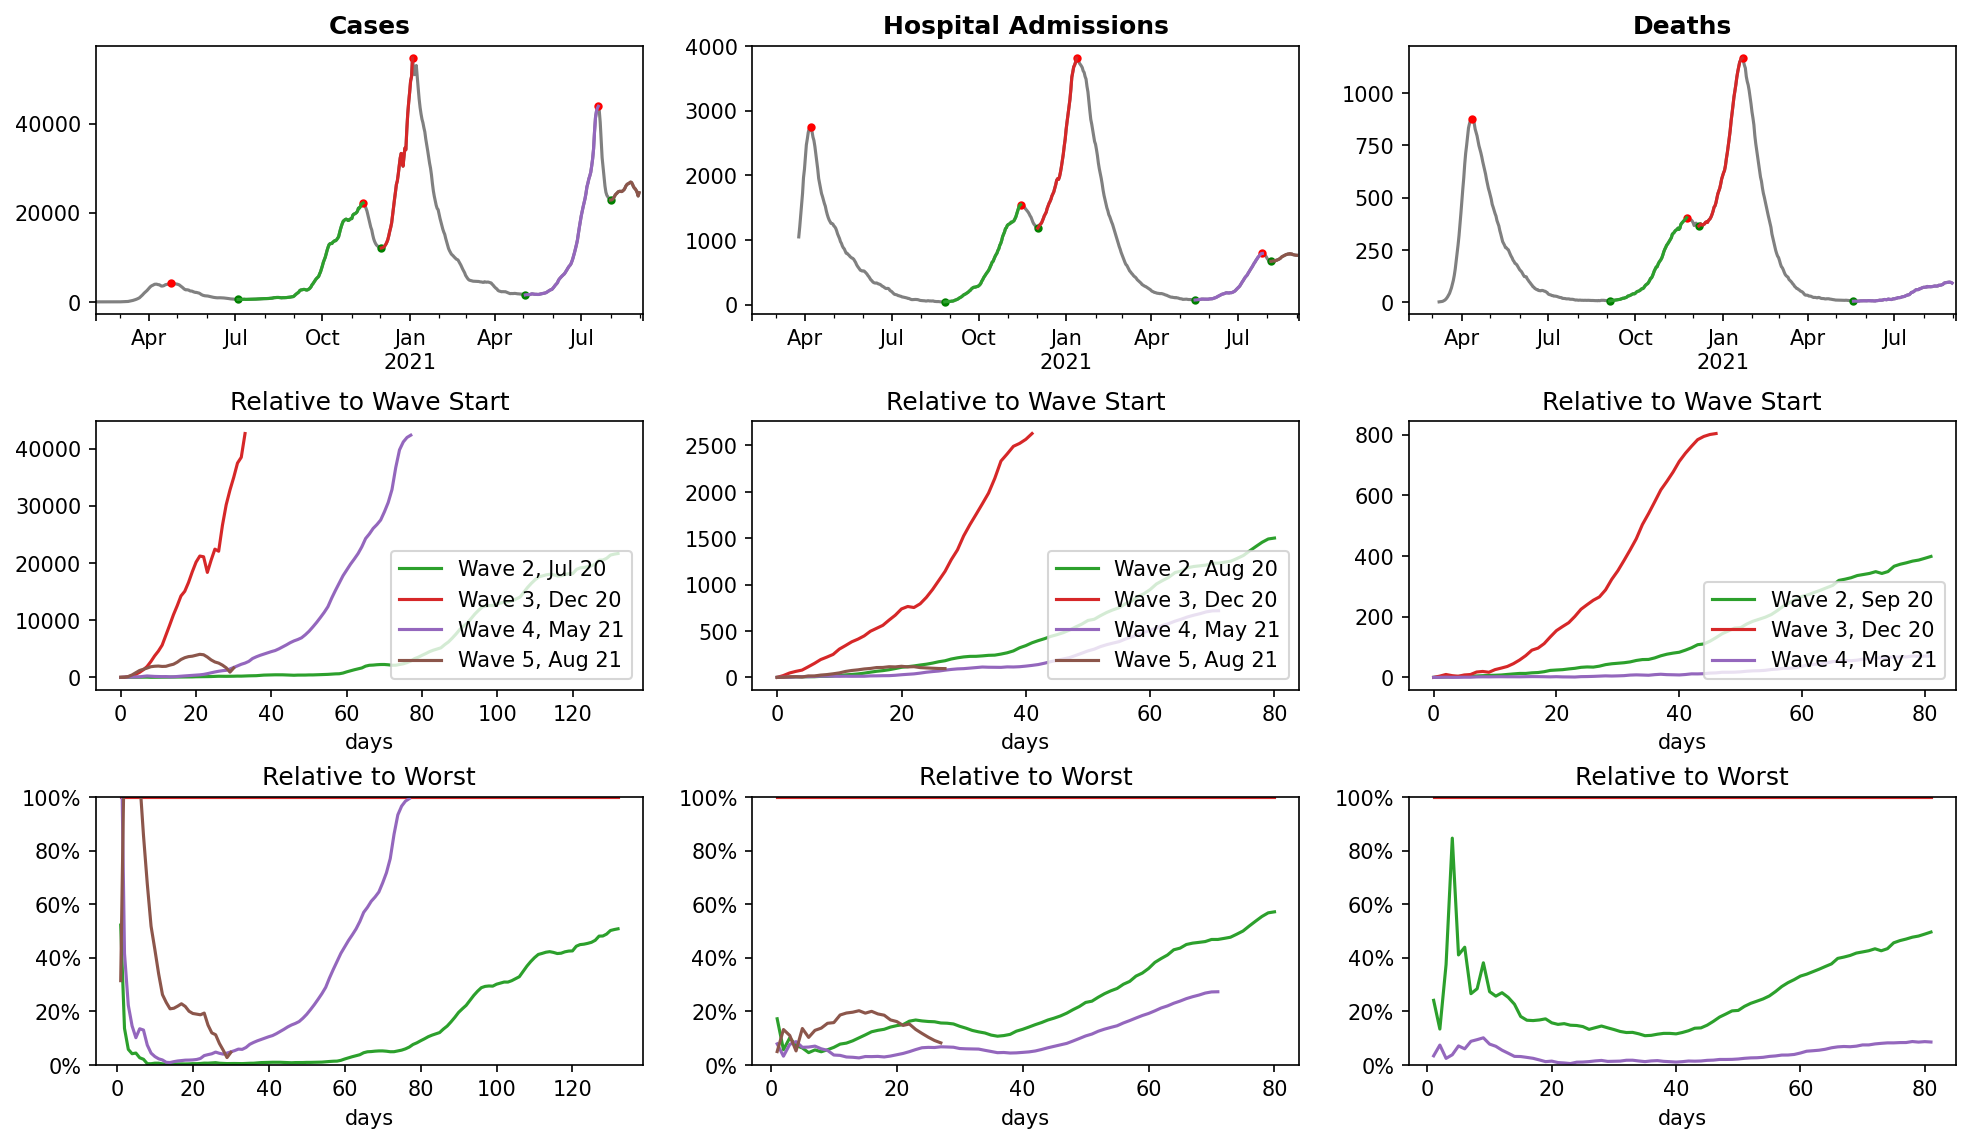

In [4]:
plot_all(figsize=(16, 9), hspace=0.4, logy=False)

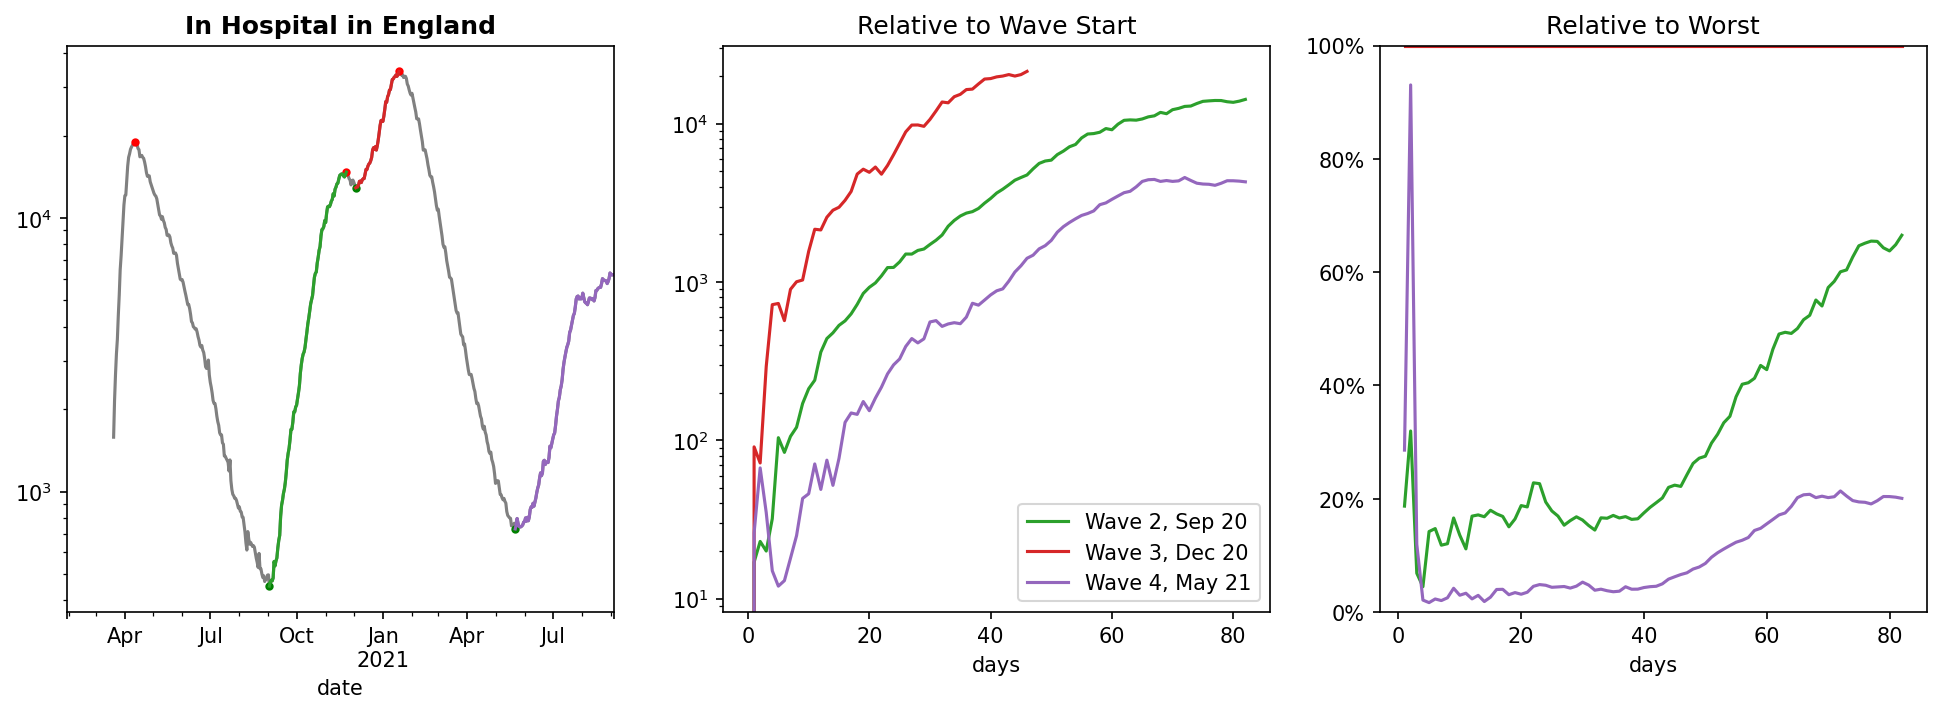

In [5]:
data, _ = best_data(area_type=nation, areas=[england], metric=in_hospital, date_index=True)
waves(data, in_hospital, 'In Hospital in England')